In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from ckonlpy.tag import Twitter
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette("hls")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
train = pd.read_json("../arena_data/orig/train.json")
val_q_df = pd.read_json("../arena_data/questions/val.json") # val 데이터의 각 플레이스트를 50%로 분할
val_a_df = pd.read_json("../arena_data/answers/val.json") # 정답 데이터

In [3]:
train_df = pd.concat([train, val_q_df])
train_df

,tags,id,plylst_title,songs,like_cnt,updt_date
0,"[힐링, 휴식, 밤, 새벽]",147668,To. 힘들고 지친 분들에게,"[663185, 649626, 6855, 188486, 348451, 169945,...",12,2016-06-23 10:06:27.000
1,[팝],50422,130807-7,"[627035, 256438, 603324, 200889, 441319, 21689...",0,2013-08-15 13:17:11.000
2,[뉴에이지],116432,숙면을 위한 슬픈 마음을 달래 줄 피아노,"[129204, 369497, 649743, 344619, 110281, 63266...",23,2015-09-03 16:51:50.000
3,"[하드락, 록스피릿, 댄스]",55076,당신을 하얗게 불태울 곡들,"[677591, 420396, 104934, 119279, 251988, 58850...",1,2017-01-09 15:41:25.000
4,"[힐링, 휴식, 기분전환]",125064,[스피커 필수 / HIPHOP] 듣고 있음 꿀렁꿀렁이고 싶은 힙합음악!,"[704455, 694036, 508043, 154933, 57614, 645195...",715,2016-02-22 12:32:50.000
...,...,...,...,...,...,...
23010,[],132039,이것만 알아도 브릿팝 안다는 소리듣는다.,"[8778, 5725, 234307, 64368, 691112, 581349, 40...",232,2014-03-10 19:08:16.000
23011,[],21475,make015,"[470489, 72225, 387567, 328452, 517417, 690761...",0,2016-05-16 15:34:18.000
23012,"[힘들때, 지칠때, 힘내]",81196,"힘든 걸 알아, 말해주고 싶었어요","[448250, 131741, 531820, 616260, 639943, 13129...",13,2017-12-20 16:32:07.000
23013,[],151600,♥Christmas Music♥,[],8,2015-12-23 09:38:19.000


In [4]:
def re_sub(series: pd.Series) -> pd.Series:
    series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True)  # 공백 제거
    series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True)  # u3000 제거
    return series

In [5]:
# 공백 제거, u3000 제거
train_df['plylst_title'] = re_sub(train_df['plylst_title'])
# 제목 모두 소문자로 변경
train_df['plylst_title'] = train_df['plylst_title'].apply(lambda x: x.lower())
train_df

,tags,id,plylst_title,songs,like_cnt,updt_date
0,"[힐링, 휴식, 밤, 새벽]",147668,to. 힘들고 지친 분들에게,"[663185, 649626, 6855, 188486, 348451, 169945,...",12,2016-06-23 10:06:27.000
1,[팝],50422,130807-7,"[627035, 256438, 603324, 200889, 441319, 21689...",0,2013-08-15 13:17:11.000
2,[뉴에이지],116432,숙면을 위한 슬픈 마음을 달래 줄 피아노,"[129204, 369497, 649743, 344619, 110281, 63266...",23,2015-09-03 16:51:50.000
3,"[하드락, 록스피릿, 댄스]",55076,당신을 하얗게 불태울 곡들,"[677591, 420396, 104934, 119279, 251988, 58850...",1,2017-01-09 15:41:25.000
4,"[힐링, 휴식, 기분전환]",125064,[스피커 필수 / hiphop] 듣고 있음 꿀렁꿀렁이고 싶은 힙합음악!,"[704455, 694036, 508043, 154933, 57614, 645195...",715,2016-02-22 12:32:50.000
...,...,...,...,...,...,...
23010,[],132039,이것만 알아도 브릿팝 안다는 소리듣는다.,"[8778, 5725, 234307, 64368, 691112, 581349, 40...",232,2014-03-10 19:08:16.000
23011,[],21475,make015,"[470489, 72225, 387567, 328452, 517417, 690761...",0,2016-05-16 15:34:18.000
23012,"[힘들때, 지칠때, 힘내]",81196,"힘든 걸 알아, 말해주고 싶었어요","[448250, 131741, 531820, 616260, 639943, 13129...",13,2017-12-20 16:32:07.000
23013,[],151600,♥christmas music♥,[],8,2015-12-23 09:38:19.000


In [6]:
train_df[train_df['plylst_title'].str.contains('christmas', na = False)][-20:]

,tags,id,plylst_title,songs,like_cnt,updt_date
3644,[크리스마스],78096,christmas,[],0,2020-02-17 16:11:38.000
4320,[],138133,따뜻한 선물 같은 christmas cafe 501,"[657321, 458058, 179652, 690859, 7517, 230540,...",0,2019-05-09 13:51:30.000
4424,[소울],15958,r&b christmas 알앤비 크리스마스,"[214813, 356977, 230532, 90960, 362123, 432291...",52,2013-12-13 13:45:45.000
4595,[겨울],81670,그리웠어! 기다렸어! 추억을 회상할 merry christmas 32곡!,"[387546, 656881, 589910, 440773, 392325, 41971...",19,2016-11-21 22:07:50.000
5803,[],130280,christmas afternoon,"[396550, 470392, 216256, 423386, 326204]",0,2013-12-13 12:27:42.000
6451,"[연말, 노동요, 겨울감성, 카페, 분위기]",152874,♥행복한 크리스마스 white christmas jazz 연주곡♥,[],193,2017-12-01 01:24:41.000
9163,"[사랑, 밤]",49637,루비스라디오)진선의'음악선물'18화-christmas with 음악선물,"[506535, 281647, 84804, 354141, 315328, 334839]",1,2014-12-10 10:51:48.000
9237,"[알앤비, RnB, 크리스마스, Christmas]",109914,❤ soulful christmas carols ❤,[],2583,2019-12-01 22:10:18.000
11428,[기분전환],41791,크리스마스 이니깐~christmas,"[637135, 369633, 105433, 328024, 526035, 35593...",16,2015-11-28 05:20:22.000
11524,[],124275,old pop christmas songs,"[662302, 296906, 251522, 670743, 273672, 42743...",96,2017-11-23 11:44:05.000


In [7]:
#word count
word_counts = train_df['plylst_title'].apply(lambda x:len(x.split(' ')))
word_counts.describe()

count    115071.000000
mean          4.371762
std           2.080720
min           1.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          19.000000
Name: plylst_title, dtype: float64

In [8]:
train_df['plylst_title']

0                                to. 힘들고 지친 분들에게
1                                       130807-7
2                         숙면을 위한 슬픈 마음을 달래 줄 피아노
3                                 당신을 하얗게 불태울 곡들
4        [스피커 필수 / hiphop] 듣고 있음 꿀렁꿀렁이고 싶은 힙합음악!
                          ...                   
23010                     이것만 알아도 브릿팝 안다는 소리듣는다.
23011                                    make015
23012                         힘든 걸 알아, 말해주고 싶었어요
23013                          ♥christmas music♥
23014                                    라디오 389
Name: plylst_title, Length: 115071, dtype: object

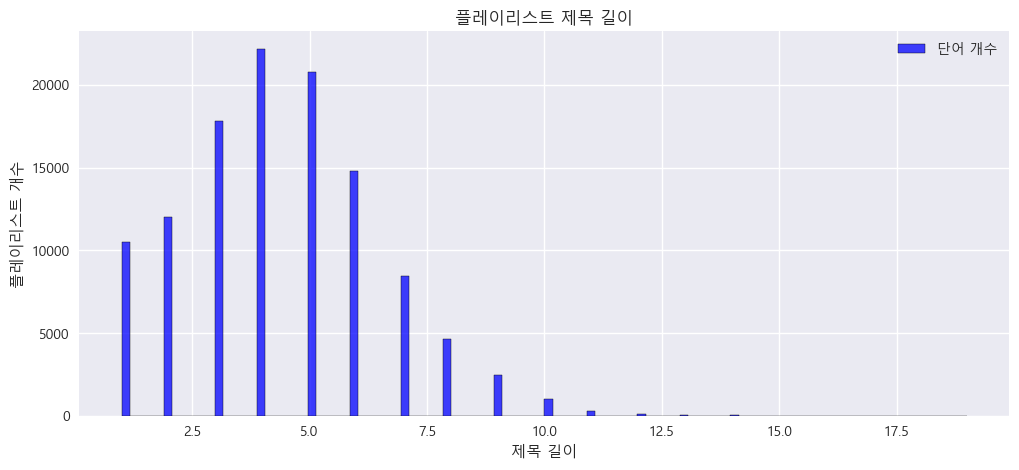

In [9]:
plt.figure(figsize=(12, 5))
ax = sns.histplot(word_counts,kde=False,bins=100,color='b')
ax.set_xlabel('제목 길이')
ax.set_ylabel('플레이리스트 개수')
ax.set_title('플레이리스트 제목 길이')
ax.legend(labels=['단어 개수'])
plt.show()

In [10]:
train_df[train_df['plylst_title'].str.contains('rock music', na = False)]

,tags,id,plylst_title,songs,like_cnt,updt_date
1482,"[록메탈, 락, Metal, 메탈, Rock, 록]",37100,fantastic rock music world .02,"[603296, 504238, 143561, 448473, 446361, 28506...",0,2019-11-30 21:05:50.000
14175,"[록메탈, 락, Metal, 메탈, Rock, 록]",29441,fantastic rock music world .01,"[234038, 435621, 428556, 696546, 361518, 36007...",0,2019-11-30 21:03:49.000
43907,"[스트레스, 락]",69975,스트레스 해소! 화끈한 rock music,"[649566, 91125, 91104, 215080, 459512, 567648,...",6,2016-03-23 11:15:53.000
52596,[락],98253,my favorite rock music,"[175230, 196427, 37298, 183097, 157627, 193223...",5,2016-05-01 12:41:08.000
75744,[락],61572,남자의 느낌충만한 rock music 20선,"[328829, 545663, 50228, 28347, 637635, 489447,...",6,2014-05-30 13:50:14.000
88530,"[봄, 해외, 월요일, 비타민감성, 포크, 드라이브, 나른할때, 춘곤증, 록, 오후]",132093,"무기력한 오후, 나른함을 떨쳐버릴 비타민 감성 rock music!","[690653, 696512, 101215, 48634, 598846, 144503...",19,2019-04-22 13:49:39.000
13785,[],30733,energetic rock music with raw sounds,"[302784, 622083, 287577, 463499, 84087, 404546...",4,2014-09-04 12:32:57.000


In [11]:
twitter = Twitter()

twitter.add_dictionary('기분전환', 'Noun')
twitter.add_dictionary('에릭', 'Noun')
twitter.add_dictionary('클랩튼', 'Noun')
twitter.add_dictionary('r&b', 'Noun')
twitter.add_dictionary('hip hop', 'Noun')

In [12]:
# 불용어 정의
stopwords = ['it', 's', 'to', 'and', '그리고', '의','가','이','은','들', '는', '.', '[', '/', ']', "'", '~', ',', '위', '『', '』',
             '것', '만', '에게', '분', '줄', '(', ')', '좀','잘','걍','과','도', '을', '를','으로','자','에','와','한', '있다',
             '하다', '알다', '안다', '걸', '알', '아', '이고', '엔', '그', '어요']

tokenized_data = []
for sentence in tqdm(train_df['plylst_title']):
    tokenized_sentence = twitter.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████| 115071/115071 [00:29<00:00, 3956.25it/s]


In [13]:
tokenized_data

[['힘들다', '지치다', '분들'],
 ['130807-7'],
 ['숙면', '슬프다', '마음', '달래', '피아노'],
 ['당신', '하얗다', '불', '태우다', '곡'],
 ['스피커', '필수', 'hiphop', '듣다', '꿀렁꿀렁', '싶다', '힙합', '음악', '!'],
 ['요즘', '듣다', '노래', '2'],
 ['tthing', '하루'],
 ['분위기', 'lofi', 'rnb', '모음'],
 ['가을', '하늘', 'edm', '함께', '!', '일', '렉', '트릭', '스카이', '뮤직', '페스티벌', '프리뷰'],
 ['발라드', '감성', '재'],
 ['♤', '겨울', '이면', '생각', '나', '늘다', '들려오다', '노래', '들다', '♤'],
 ['한중일', '꿀', '보이스', '삼대', '장'],
 ['늦다', '봄', '이별', '후'],
 ['game'],
 ['lany', 'live', 'in', 'seoul', '2019', '내한', '예상', '세트리스트'],
 ['따뜻하다', '봄날', '달달', '피아노', '뮤직'],
 ['방대', '양', '듀엣곡', '종결', '리스트'],
 ['#rnb', 'soul'],
 ['몽롱',
  '감성',
  '락',
  '!',
  '시끄럽다',
  '락',
  '아니다',
  '락',
  '발라드',
  '!',
  '명곡',
  '쏟아',
  '지다',
  '!!'],
 ['히피', '집시', '이다'],
 ['내', '스타일', '심야', '데이트'],
 ['룰루', '드라이빙', '뮤직', '!'],
 ['❤', 'dj', '추천', '1월', '신곡', '일렉트로니카', '모음', '❤'],
 ['잔잔', '여름'],
 ['20', '대다', '후반', '친구', '들다', '들다', '좋다', '노래'],
 ['pop', '순이', '추', '천하', 'fall', 'out', 'boy'],
 ['christmas', 'j

In [14]:
train_df['tokenized_title'] = tokenized_data
train_df

,tags,id,plylst_title,songs,like_cnt,updt_date,tokenized_title
0,"[힐링, 휴식, 밤, 새벽]",147668,to. 힘들고 지친 분들에게,"[663185, 649626, 6855, 188486, 348451, 169945,...",12,2016-06-23 10:06:27.000,"[힘들다, 지치다, 분들]"
1,[팝],50422,130807-7,"[627035, 256438, 603324, 200889, 441319, 21689...",0,2013-08-15 13:17:11.000,[130807-7]
2,[뉴에이지],116432,숙면을 위한 슬픈 마음을 달래 줄 피아노,"[129204, 369497, 649743, 344619, 110281, 63266...",23,2015-09-03 16:51:50.000,"[숙면, 슬프다, 마음, 달래, 피아노]"
3,"[하드락, 록스피릿, 댄스]",55076,당신을 하얗게 불태울 곡들,"[677591, 420396, 104934, 119279, 251988, 58850...",1,2017-01-09 15:41:25.000,"[당신, 하얗다, 불, 태우다, 곡]"
4,"[힐링, 휴식, 기분전환]",125064,[스피커 필수 / hiphop] 듣고 있음 꿀렁꿀렁이고 싶은 힙합음악!,"[704455, 694036, 508043, 154933, 57614, 645195...",715,2016-02-22 12:32:50.000,"[스피커, 필수, hiphop, 듣다, 꿀렁꿀렁, 싶다, 힙합, 음악, !]"
...,...,...,...,...,...,...,...
23010,[],132039,이것만 알아도 브릿팝 안다는 소리듣는다.,"[8778, 5725, 234307, 64368, 691112, 581349, 40...",232,2014-03-10 19:08:16.000,"[브릿팝, 소리, 듣다]"
23011,[],21475,make015,"[470489, 72225, 387567, 328452, 517417, 690761...",0,2016-05-16 15:34:18.000,"[make, 015]"
23012,"[힘들때, 지칠때, 힘내]",81196,"힘든 걸 알아, 말해주고 싶었어요","[448250, 131741, 531820, 616260, 639943, 13129...",13,2017-12-20 16:32:07.000,"[힘드다, 말, 해주, 고, 싶다]"
23013,[],151600,♥christmas music♥,[],8,2015-12-23 09:38:19.000,"[♥, christmas, music, ♥]"


토큰화된 title의 최대 길이 : 27
토큰화된 title의 평균 길이 : 6.170042843114251


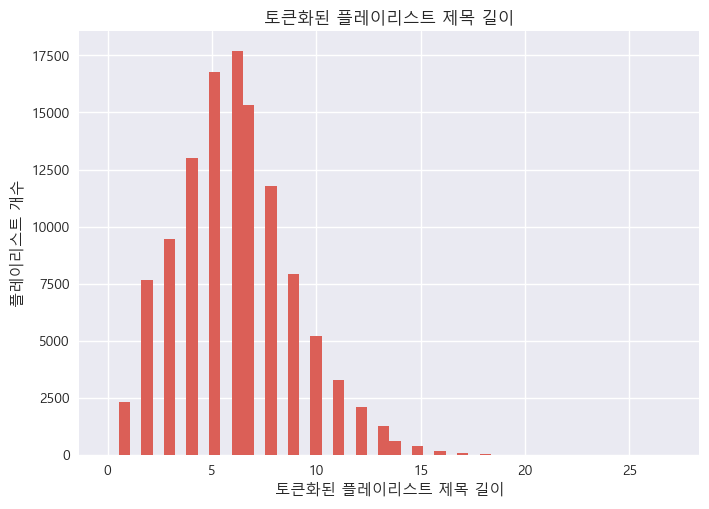

In [29]:
# 리 뷰 길 이 분 포 확 인
print('토큰화된 title의 최대 길이 :',max(len(review) for review in tokenized_data))
print('토큰화된 title의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('토큰화된 플레이리스트 제목 길이')
plt.ylabel('플레이리스트 개수')
plt.title('토큰화된 플레이리스트 제목 길이')
plt.show()

In [16]:
title_tags = []
for i in tqdm(range(len(train_df))):
    title_tags.append(train_df.iloc[i]['tags'] + train_df.iloc[i]['tokenized_title'])
title_tags

100%|████████████████████████████████████████████████████████████████████████| 115071/115071 [00:12<00:00, 9414.24it/s]


[['힐링', '휴식', '밤', '새벽', '힘들다', '지치다', '분들'],
 ['팝', '130807-7'],
 ['뉴에이지', '숙면', '슬프다', '마음', '달래', '피아노'],
 ['하드락', '록스피릿', '댄스', '당신', '하얗다', '불', '태우다', '곡'],
 ['힐링',
  '휴식',
  '기분전환',
  '스피커',
  '필수',
  'hiphop',
  '듣다',
  '꿀렁꿀렁',
  '싶다',
  '힙합',
  '음악',
  '!'],
 ['요즘듣는노래', '요즘', '듣다', '노래', '2'],
 ['카페', '인디', 'tthing', '하루'],
 ['로우파이', '감성', '자기전에듣기좋은', '알앤비힙합', '분위기', 'lofi', 'rnb', '모음'],
 ['댄스',
  'EDM',
  '가을',
  '하늘',
  'edm',
  '함께',
  '!',
  '일',
  '렉',
  '트릭',
  '스카이',
  '뮤직',
  '페스티벌',
  '프리뷰'],
 ['발라드', '발라드', '감성', '재'],
 ['휴식',
  '힐링',
  '여행',
  '산책',
  '♤',
  '겨울',
  '이면',
  '생각',
  '나',
  '늘다',
  '들려오다',
  '노래',
  '들다',
  '♤'],
 ['밤', '까페', '새벽', '한중일', '꿀', '보이스', '삼대', '장'],
 ['발라드', '늦다', '봄', '이별', '후'],
 ['일렉', 'game'],
 ['내한',
  '감성',
  '취향저격',
  '팝',
  '인디팝',
  '밴드',
  '레이니',
  '음색',
  '록',
  'LANY',
  'lany',
  'live',
  'in',
  'seoul',
  '2019',
  '내한',
  '예상',
  '세트리스트'],
 ['카페', '피아노', '뉴에이지', '봄', '재즈', '따뜻하다', '봄날', '달달', '피아노', '뮤직'],
 ['슬픔', '이별', '

In [17]:
train_df['title_tags'] = title_tags
train_df

,tags,id,plylst_title,songs,like_cnt,updt_date,tokenized_title,title_tags
0,"[힐링, 휴식, 밤, 새벽]",147668,to. 힘들고 지친 분들에게,"[663185, 649626, 6855, 188486, 348451, 169945,...",12,2016-06-23 10:06:27.000,"[힘들다, 지치다, 분들]","[힐링, 휴식, 밤, 새벽, 힘들다, 지치다, 분들]"
1,[팝],50422,130807-7,"[627035, 256438, 603324, 200889, 441319, 21689...",0,2013-08-15 13:17:11.000,[130807-7],"[팝, 130807-7]"
2,[뉴에이지],116432,숙면을 위한 슬픈 마음을 달래 줄 피아노,"[129204, 369497, 649743, 344619, 110281, 63266...",23,2015-09-03 16:51:50.000,"[숙면, 슬프다, 마음, 달래, 피아노]","[뉴에이지, 숙면, 슬프다, 마음, 달래, 피아노]"
3,"[하드락, 록스피릿, 댄스]",55076,당신을 하얗게 불태울 곡들,"[677591, 420396, 104934, 119279, 251988, 58850...",1,2017-01-09 15:41:25.000,"[당신, 하얗다, 불, 태우다, 곡]","[하드락, 록스피릿, 댄스, 당신, 하얗다, 불, 태우다, 곡]"
4,"[힐링, 휴식, 기분전환]",125064,[스피커 필수 / hiphop] 듣고 있음 꿀렁꿀렁이고 싶은 힙합음악!,"[704455, 694036, 508043, 154933, 57614, 645195...",715,2016-02-22 12:32:50.000,"[스피커, 필수, hiphop, 듣다, 꿀렁꿀렁, 싶다, 힙합, 음악, !]","[힐링, 휴식, 기분전환, 스피커, 필수, hiphop, 듣다, 꿀렁꿀렁, 싶다, ..."
...,...,...,...,...,...,...,...,...
23010,[],132039,이것만 알아도 브릿팝 안다는 소리듣는다.,"[8778, 5725, 234307, 64368, 691112, 581349, 40...",232,2014-03-10 19:08:16.000,"[브릿팝, 소리, 듣다]","[브릿팝, 소리, 듣다]"
23011,[],21475,make015,"[470489, 72225, 387567, 328452, 517417, 690761...",0,2016-05-16 15:34:18.000,"[make, 015]","[make, 015]"
23012,"[힘들때, 지칠때, 힘내]",81196,"힘든 걸 알아, 말해주고 싶었어요","[448250, 131741, 531820, 616260, 639943, 13129...",13,2017-12-20 16:32:07.000,"[힘드다, 말, 해주, 고, 싶다]","[힘들때, 지칠때, 힘내, 힘드다, 말, 해주, 고, 싶다]"
23013,[],151600,♥christmas music♥,[],8,2015-12-23 09:38:19.000,"[♥, christmas, music, ♥]","[♥, christmas, music, ♥]"


title_tags의 최대 길이 : 29
title_tags의 평균 길이 : 9.71627951438677


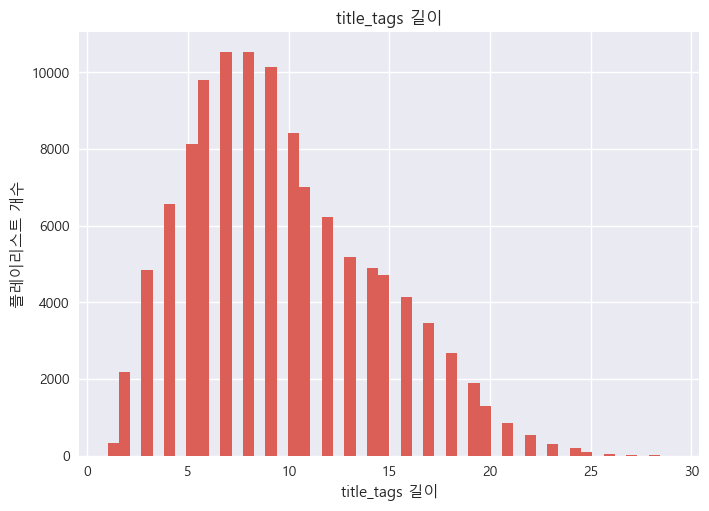

In [31]:
# 리 뷰 길 이 분 포 확 인
print('title_tags의 최대 길이 :',max(len(review) for review in title_tags))
print('title_tags의 평균 길이 :',sum(map(len, title_tags))/len(title_tags))
plt.hist([len(review) for review in title_tags], bins=50)
plt.xlabel('title_tags 길이')
plt.ylabel('플레이리스트 개수')
plt.title('title_tags 길이')
plt.show()

In [18]:
empty_titles = []
for i in range(len(train_df)):
    if len(train_df['title_tags'].iloc[i]) == 0:
        empty_titles.append(i)

if len(empty_titles) == 0:
    print('빈 데이터 없음')
else:
    print('빈 데이터 있음')
    print(empty_titles)

빈 데이터 없음


In [19]:
# train_df.to_json('train_df(filtered_title(특수기호 안 없앰)).json', orient = 'records')

In [20]:
# pd.read_json('train_df(filtered_title(특수기호 안 없앰)).json')

In [21]:
def flatten(list_of_list):
    flatten = [j for i in list_of_list for j in i]
    return flatten

def get_token(title: str, tokenizer):
    
    if len(title)== 0 or title== ' ':  # 제목이 공백인 경우 tokenizer에러 발생
        return []
    
    result = tokenizer.pos(title) 
    return result

def get_all_titles(df):
    title_list = df['tokenized_title'].values.tolist()
    title_list = flatten(title_list)
    return title_list

In [22]:
all_title = get_all_titles(train_df)
token_title = [get_token(x, twitter) for x in all_title]  # 토큰나이징된 title을 형태소 분석

In [23]:
token_title

[[('힘들다', 'Adjective')],
 [('지치다', 'Verb')],
 [('분들', 'Suffix')],
 [('130807-7', 'Number')],
 [('숙면', 'Noun')],
 [('슬프다', 'Adjective')],
 [('마음', 'Noun')],
 [('달래', 'Noun')],
 [('피아노', 'Noun')],
 [('당신', 'Noun')],
 [('하얗다', 'Adjective')],
 [('불', 'Noun')],
 [('태우다', 'Verb')],
 [('곡', 'Noun')],
 [('스피커', 'Noun')],
 [('필수', 'Noun')],
 [('hiphop', 'Alpha')],
 [('듣다', 'Verb')],
 [('꿀렁꿀렁', 'Noun')],
 [('싶다', 'Verb')],
 [('힙합', 'Noun')],
 [('음악', 'Noun')],
 [('!', 'Punctuation')],
 [('요즘', 'Noun')],
 [('듣다', 'Verb')],
 [('노래', 'Noun')],
 [('2', 'Number')],
 [('tthing', 'Alpha')],
 [('하루', 'Noun')],
 [('분위기', 'Noun')],
 [('lofi', 'Alpha')],
 [('rnb', 'Alpha')],
 [('모음', 'Noun')],
 [('가을', 'Noun')],
 [('하늘', 'Noun')],
 [('edm', 'Alpha')],
 [('함께', 'Adverb')],
 [('!', 'Punctuation')],
 [('일', 'Noun')],
 [('렉', 'Noun')],
 [('트릭', 'Noun')],
 [('스카이', 'Noun')],
 [('뮤직', 'Noun')],
 [('페스티벌', 'Noun')],
 [('프리뷰', 'Noun')],
 [('발라드', 'Noun')],
 [('감성', 'Noun')],
 [('재', 'Noun')],
 [('♤', 'Foreign')],


In [24]:
flatten_token = flatten(token_title)

In [25]:
flatten_token

[('힘들다', 'Adjective'),
 ('지치다', 'Verb'),
 ('분들', 'Suffix'),
 ('130807-7', 'Number'),
 ('숙면', 'Noun'),
 ('슬프다', 'Adjective'),
 ('마음', 'Noun'),
 ('달래', 'Noun'),
 ('피아노', 'Noun'),
 ('당신', 'Noun'),
 ('하얗다', 'Adjective'),
 ('불', 'Noun'),
 ('태우다', 'Verb'),
 ('곡', 'Noun'),
 ('스피커', 'Noun'),
 ('필수', 'Noun'),
 ('hiphop', 'Alpha'),
 ('듣다', 'Verb'),
 ('꿀렁꿀렁', 'Noun'),
 ('싶다', 'Verb'),
 ('힙합', 'Noun'),
 ('음악', 'Noun'),
 ('!', 'Punctuation'),
 ('요즘', 'Noun'),
 ('듣다', 'Verb'),
 ('노래', 'Noun'),
 ('2', 'Number'),
 ('tthing', 'Alpha'),
 ('하루', 'Noun'),
 ('분위기', 'Noun'),
 ('lofi', 'Alpha'),
 ('rnb', 'Alpha'),
 ('모음', 'Noun'),
 ('가을', 'Noun'),
 ('하늘', 'Noun'),
 ('edm', 'Alpha'),
 ('함께', 'Adverb'),
 ('!', 'Punctuation'),
 ('일', 'Noun'),
 ('렉', 'Noun'),
 ('트릭', 'Noun'),
 ('스카이', 'Noun'),
 ('뮤직', 'Noun'),
 ('페스티벌', 'Noun'),
 ('프리뷰', 'Noun'),
 ('발라드', 'Noun'),
 ('감성', 'Noun'),
 ('재', 'Noun'),
 ('♤', 'Foreign'),
 ('겨울', 'Noun'),
 ('이면', 'Noun'),
 ('생각', 'Noun'),
 ('나', 'Noun'),
 ('늘다', 'Verb'),
 ('들려오다', 'Ver

In [26]:
# Counting Part of Speech (pos)
pos = [x[1] for x in flatten_token]
pos_count = Counter(pos)
popular_pos = pos_count.most_common()

In [27]:
popular_pos

[('Noun', 459124),
 ('Verb', 68740),
 ('Alpha', 46821),
 ('Punctuation', 40294),
 ('Adjective', 30140),
 ('Number', 27543),
 ('Josa', 22810),
 ('Adverb', 11419),
 ('Foreign', 10499),
 ('Exclamation', 1138),
 ('KoreanParticle', 975),
 ('Hashtag', 730),
 ('Modifier', 635),
 ('Suffix', 586),
 ('Eomi', 525),
 ('PreEomi', 56),
 ('URL', 27),
 ('ScreenName', 19),
 ('Conjunction', 14),
 ('CashTag', 12),
 ('VerbPrefix', 11),
 ('Email', 3)]

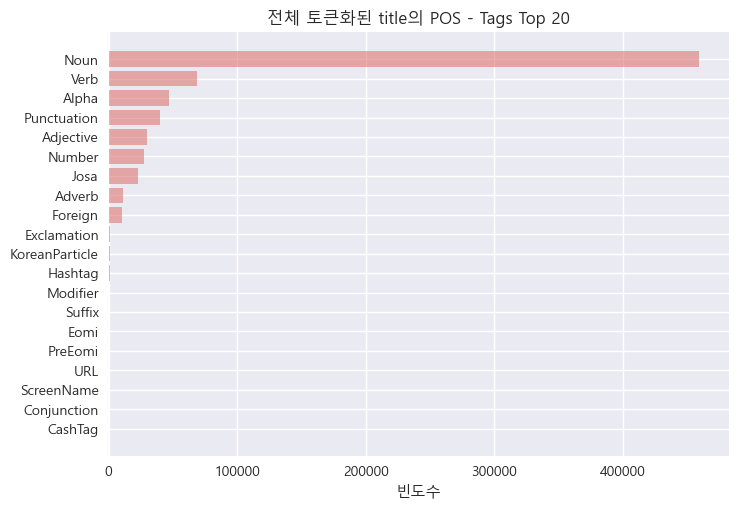

In [28]:
objects = [x[0] for x in popular_pos[:20]]
y_pos = np.arange(len(objects))
performance = [x[1] for x in popular_pos[:20]]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.gca().invert_yaxis()
plt.xlabel('빈도수')
plt.title('전체 토큰화된 title의 POS - Tags Top 20')

plt.show()